# PM2.5 prediction

### Import libraries

In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
from scipy.stats import stats
seed(1)
from fs import methods as m
from fs import model as ml
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


### Data Import

/Users/Brescia/Desktop/D-DUST/notebooks/fs/methods.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nB = np.array(list(data.geometry.centroid.apply(lambda x: (x.x, x.y))))
2022-05-22 17:05:57.521838: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-22 17:05:57.523068: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


---------grid_0_1_0418_0425_2021.gpkg---------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


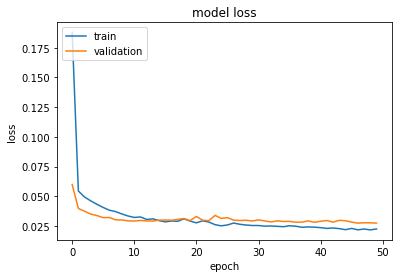

Values predicted:  [[21.553242]
 [17.676388]
 [20.64139 ]
 [17.115635]
 [20.56432 ]
 [20.740406]
 [18.24686 ]
 [18.84056 ]
 [21.041113]
 [16.22815 ]
 [14.111236]
 [21.1524  ]
 [18.95445 ]
 [20.507172]
 [19.019114]
 [21.50462 ]
 [20.501095]
 [14.432171]
 [17.722483]
 [14.922582]
 [18.688707]
 [20.195347]
 [19.56927 ]
 [21.520319]
 [20.085308]
 [19.648027]
 [17.89125 ]
 [17.59285 ]
 [19.775837]
 [19.715754]
 [20.290134]
 [21.569773]
 [20.104656]
 [17.441807]
 [19.913994]
 [19.720821]
 [17.001408]
 [18.564377]
 [19.28692 ]
 [15.016618]
 [15.971237]
 [19.727186]
 [18.052946]
 [15.190604]
 [18.663033]
 [17.71943 ]
 [21.180664]
 [16.97045 ]
 [21.011045]
 [19.575361]
 [19.620718]
 [17.82871 ]
 [16.136581]
 [19.168442]]
Values :  [[23.77451484]
 [18.18160347]
 [20.30819625]
 [17.10270714]
 [18.83298897]
 [15.9683037 ]
 [18.97437529]
 [19.78888917]
 [21.1561387 ]
 [17.69204367]
 [15.12911068]
 [22.55729673]
 [20.12699447]
 [17.43185004]
 [15.66264512]
 [21.68441366]
 [19.54443945]
 [13.17174129

/Users/Brescia/Desktop/D-DUST/notebooks/fs/methods.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nB = np.array(list(data.geometry.centroid.apply(lambda x: (x.x, x.y))))


dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


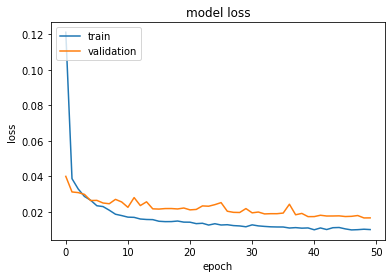

Values predicted:  [[18.59487  ]
 [13.003511 ]
 [19.658571 ]
 [12.477326 ]
 [12.469739 ]
 [16.843279 ]
 [12.074736 ]
 [14.434574 ]
 [12.237317 ]
 [15.1105175]
 [15.215287 ]
 [15.011245 ]
 [12.162257 ]
 [12.336831 ]
 [16.460472 ]
 [20.829655 ]
 [18.853298 ]
 [18.577873 ]
 [12.978909 ]
 [12.412771 ]
 [16.840061 ]
 [12.528651 ]
 [12.026801 ]
 [12.452323 ]
 [12.804426 ]
 [17.732246 ]
 [15.606607 ]
 [14.735371 ]
 [17.936789 ]
 [12.477197 ]
 [12.244101 ]
 [17.422657 ]
 [14.000034 ]
 [13.963252 ]
 [16.846003 ]
 [12.19997  ]
 [12.349058 ]
 [14.5892725]
 [16.931664 ]
 [12.373948 ]
 [14.516125 ]
 [17.211866 ]
 [12.528733 ]
 [13.02472  ]
 [12.818717 ]
 [12.2027645]
 [13.344548 ]
 [15.943768 ]
 [14.698042 ]
 [12.574699 ]
 [12.891713 ]
 [16.403893 ]
 [13.358589 ]
 [17.321623 ]]
Values :  [[19.48839036]
 [13.48024522]
 [24.43408639]
 [13.12929398]
 [11.209024  ]
 [16.31562549]
 [13.28140952]
 [15.43671202]
 [10.5209441 ]
 [17.095317  ]
 [17.13729039]
 [15.93881176]
 [14.26118349]
 [13.61696971]
 [19

/Users/Brescia/Desktop/D-DUST/notebooks/fs/methods.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nB = np.array(list(data.geometry.centroid.apply(lambda x: (x.x, x.y))))


---------grid_0_1_1007_1017_2021.gpkg---------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


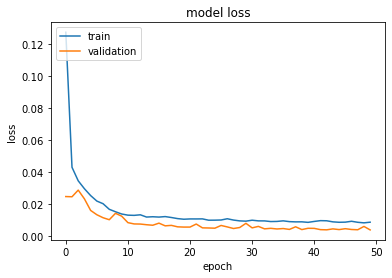

Values predicted:  [[19.64046  ]
 [17.31826  ]
 [13.119264 ]
 [21.580727 ]
 [24.474861 ]
 [21.603933 ]
 [24.15301  ]
 [13.901895 ]
 [15.180138 ]
 [15.496833 ]
 [21.298672 ]
 [22.801052 ]
 [13.967994 ]
 [12.008757 ]
 [23.184448 ]
 [24.085299 ]
 [13.208404 ]
 [18.447004 ]
 [15.767635 ]
 [22.536234 ]
 [18.483015 ]
 [13.934403 ]
 [16.94613  ]
 [11.817533 ]
 [22.575956 ]
 [14.813366 ]
 [24.027096 ]
 [13.808718 ]
 [15.793719 ]
 [23.272324 ]
 [24.342312 ]
 [13.112048 ]
 [14.392662 ]
 [14.592006 ]
 [11.721818 ]
 [12.2965555]
 [15.753436 ]
 [16.896032 ]
 [15.613447 ]
 [13.533119 ]
 [14.919793 ]
 [11.861116 ]
 [15.929641 ]
 [20.740837 ]
 [20.846384 ]
 [14.845836 ]
 [22.750868 ]
 [22.50622  ]
 [19.864197 ]
 [24.471113 ]
 [15.697711 ]
 [23.575413 ]
 [13.631859 ]
 [19.934872 ]]
Values :  [[16.83012585]
 [17.33017171]
 [15.24995015]
 [23.11855415]
 [24.01534305]
 [21.45439474]
 [26.44425747]
 [14.97053962]
 [15.74134958]
 [19.6794674 ]
 [19.66844158]
 [21.7950776 ]
 [15.44439399]
 [11.05030324]
 [24

/Users/Brescia/Desktop/D-DUST/notebooks/fs/methods.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nB = np.array(list(data.geometry.centroid.apply(lambda x: (x.x, x.y))))


---------grid_0_1_0717_0724_2021.gpkg---------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


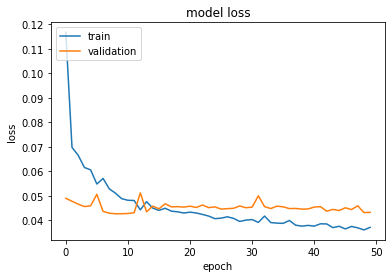

Values predicted:  [[14.451558 ]
 [13.519343 ]
 [12.652614 ]
 [12.2664585]
 [12.781326 ]
 [12.428924 ]
 [14.8108425]
 [13.46498  ]
 [11.664171 ]
 [11.659421 ]
 [12.551662 ]
 [11.849855 ]
 [12.091297 ]
 [14.424673 ]
 [13.206686 ]
 [11.094819 ]
 [12.716592 ]
 [11.994244 ]
 [12.512866 ]
 [12.07174  ]
 [12.410762 ]
 [11.285636 ]
 [13.0197115]
 [12.489782 ]
 [12.27321  ]
 [12.933569 ]
 [12.722004 ]
 [13.242017 ]
 [12.521945 ]
 [12.534606 ]
 [13.122857 ]
 [14.065989 ]
 [13.531757 ]
 [12.313805 ]
 [12.597369 ]
 [13.275923 ]
 [12.369753 ]
 [12.948669 ]
 [11.655849 ]
 [12.670931 ]
 [11.560213 ]
 [12.843454 ]
 [13.68965  ]
 [13.354155 ]
 [12.985113 ]
 [11.902317 ]
 [12.468806 ]
 [13.561401 ]
 [12.180819 ]
 [12.366574 ]
 [12.865681 ]
 [12.325676 ]
 [12.79991  ]
 [14.027615 ]]
Values :  [[14.41679057]
 [14.13675726]
 [14.06678223]
 [12.23161279]
 [13.35796078]
 [11.35341479]
 [14.64397603]
 [14.0427941 ]
 [12.60604687]
 [10.20311679]
 [12.7852054 ]
 [14.06662131]
 [14.71371341]
 [12.96398017]
 [14

/Users/Brescia/Desktop/D-DUST/notebooks/fs/methods.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nB = np.array(list(data.geometry.centroid.apply(lambda x: (x.x, x.y))))


---------grid_0_1_0324_0331_2021.gpkg---------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


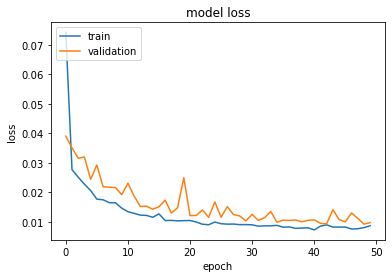

Values predicted:  [[28.254217]
 [24.884922]
 [32.47502 ]
 [25.617922]
 [23.970959]
 [29.643747]
 [24.670403]
 [24.479294]
 [24.260199]
 [26.851723]
 [26.331602]
 [34.521114]
 [28.954493]
 [26.581383]
 [35.278694]
 [24.922098]
 [27.811247]
 [39.76722 ]
 [24.097775]
 [36.9975  ]
 [28.13097 ]
 [30.162548]
 [30.464083]
 [30.704163]
 [32.38872 ]
 [31.918564]
 [23.498304]
 [29.008663]
 [33.409073]
 [29.997158]
 [25.663897]
 [32.611877]
 [26.114254]
 [29.6575  ]
 [24.82187 ]
 [26.294867]
 [24.188677]
 [24.716255]
 [24.755457]
 [28.853004]
 [22.753841]
 [23.508158]
 [26.380213]
 [28.731434]
 [28.146973]
 [29.895914]
 [28.677626]
 [23.598064]
 [23.697903]
 [31.619757]
 [36.52012 ]
 [30.240414]
 [23.698074]
 [22.233917]]
Values :  [[29.42382081]
 [26.77829   ]
 [36.79032711]
 [28.25568814]
 [28.00805988]
 [26.30661897]
 [23.23971302]
 [25.91806342]
 [24.84431857]
 [28.65555018]
 [27.08652179]
 [33.95063902]
 [35.17436908]
 [27.169378  ]
 [38.26921113]
 [24.46832271]
 [26.5970461 ]
 [42.4983998 

In [2]:
RESOLUTION = '0_1'
geopackages = os.listdir('grids_'+RESOLUTION)

TARGET = 'pm25_st'
NUMBER_OF_PARAMS = 8
NUMBER_OF_COVARIATES = NUMBER_OF_PARAMS + 2

results1 = pd.DataFrame(columns=['MAE', 'MSE', 'mean Y-Test', 'mean Y-predicted', 'R2'])
results2 = pd.DataFrame(columns=['MAE', 'MSE', 'mean Y-Test', 'mean Y-predicted', 'R2'])



for index, grid in enumerate(geopackages):
    data = m.increase_data(gpd.read_file('grids_'+RESOLUTION+'/'+ grid), 'pm25_st', 5)
    coll = pd.DataFrame()
    coll['pm25_st'] = data['pm25_st']
    coll['pm25_cams'] = data['pm25_cams']
    coll = coll.dropna(axis=0)

    #print('Mean Absolute Error: ',mean_absolute_error(coll['pm25_cams'], coll['pm25_st'], ))
    #print('Mean Squared Error: ',mean_squared_error(coll['pm25_cams'], coll['pm25_st']))
    #print('R2 score: ',r2_score(coll['pm25_cams'], coll['pm25_st']))

    points_st = gpd.read_file('arpa_stations/pm25_st.gpkg')

    data = m.add_buffer(points_st, data, data, 10)


    data = data[~data[TARGET].isnull()]
    data = data.dropna(axis=1)


    data.pop('geometry')
    data.pop('bottom')
    data.pop('top')
    data.pop('left')
    data.pop('right')


    labels = pd.read_csv('features_' +RESOLUTION +'/'+grid[:-5]+'.csv')['Features']
    #labels = pd.read_csv('fs.csv')['Features']

    labels = ml.remove_int_values(labels.tolist())
    #data.pop('pm25_cams')
    #labels.remove('pm25_cams')


    #read variables which are not null
    score_results = pd.DataFrame()

    #Store dataset in x and y variables
    X = pd.DataFrame(data=data, columns=labels ).dropna(axis = 1)
    X = X.iloc[:, :NUMBER_OF_PARAMS]
    X['lat_cen'] = data['lat_cen']
    X['lng_cen'] = data['lng_cen']

    Y = pd.DataFrame(data=data, columns=[TARGET] )
    Y = Y.values.ravel()


    #NUMBER_OF_COVARIATES = X.shape[1]
    y1 = np.array(Y)

    X_train, X_val, y_train, y_val = train_test_split(X, y1, test_size=0.30)

    y_train=np.reshape(y_train, (-1,1))
    y_val=np.reshape(y_val, (-1,1))

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_x.fit(X_train)
    xtrain_scale=scaler_x.transform(X_train)
    scaler_x.fit(X_val)
    xval_scale=scaler_x.transform(X_val)

    scaler_y.fit(y_train)
    ytrain_scale=scaler_y.transform(y_train)
    scaler_y.fit(y_val)
    yval_scale=scaler_y.transform(y_val)


    print('---------'+ grid +'---------')

    model = Sequential()
    model.add(Dense(NUMBER_OF_COVARIATES, input_dim=NUMBER_OF_COVARIATES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(NUMBER_OF_COVARIATES/2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])



    history=model.fit(xtrain_scale, ytrain_scale, epochs=50, batch_size=1, verbose=0, validation_split=0.30)
    predictions = model.predict(xval_scale)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.plot(history.history['accuracy'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = scaler_y.inverse_transform(predictions)


    results1.loc[index]= [round(mean_absolute_error(y_val, predictions),3), round(mean_squared_error(y_val, predictions),3), round(np.mean(y_val), 3), round(np.mean(predictions), 3), round(r2_score(y_val, predictions), 3)]
    results1.rename(index={index: grid}, inplace=True)





    print('Values predicted: ', predictions)
    print('Values : ', scaler_y.inverse_transform(yval_scale))
    print('---------VALIDATION WITH ARPA (TEST_SET)---------')

    print('Mean Absolute Error: ',mean_absolute_error(y_val, predictions))
    print('Mean Squared Error: ',mean_squared_error(y_val, predictions))
    print('Mean (Y-test):',np.mean(y_val))
    print('Mean (Y-predicted): ',np.mean(predictions))
    print('R2 score: ',r2_score(y_val, predictions))

    #%%

    data_new = m.increase_data(gpd.read_file('grids_'+RESOLUTION+'/'+ grid), 'pm25_st', 5)
    data_new = data_new[~data_new[TARGET].isnull()]
    pm25_obs = data_new['pm25_st']
    X_new = pd.DataFrame(data=data_new, columns=labels).dropna(axis=1)
    X_new = X_new.iloc[:, :NUMBER_OF_PARAMS]

    X_new['lat_cen'] = data_new['lat_cen']
    X_new['lng_cen'] = data_new['lng_cen']
    scaler_x = MinMaxScaler()
    scaler_x.fit(X_new)
    X_new_scale=scaler_x.transform(X_new)




    predictions_pm25 = model.predict(X_new_scale,  batch_size=1)
    predictions_pm25 = pd.Series(np.array(scaler_y.inverse_transform(predictions_pm25)).reshape((-1,)))
    e = pd.DataFrame()

    e['predictions_pm25'] = list(predictions_pm25)
    e['pm25_obs'] = list(pm25_obs)
    e = e.dropna(axis=0)
    print('---------VALIDATION WITH ARPA (ALL)---------')
    print('Mean Absolute Error: ',mean_absolute_error(e['pm25_obs'], e['predictions_pm25']))
    print('Mean Squared Error: ',mean_squared_error(e['pm25_obs'], e['predictions_pm25']))
    print('Mean (Y-test):',np.mean(e['pm25_obs']))
    print('Mean (Y-predicted): ',np.mean(e['predictions_pm25']))
    print('R2 score: ',r2_score(e['pm25_obs'], e['predictions_pm25']))

    results2.loc[index]= [round(mean_absolute_error(e['pm25_obs'], e['predictions_pm25']),3), round(mean_squared_error(e['pm25_obs'], e['predictions_pm25']),3), round(np.mean(e['pm25_obs']),3), round(np.mean(e['predictions_pm25']),3), round(r2_score(e['pm25_obs'], e['predictions_pm25']),3)]
    results2.rename(index={index: grid}, inplace=True)

results1 = results1.T
results2 = results2.T

results1.to_excel('test/keras1'+RESOLUTION+'.xlsx')
results2.to_excel('test/keras2'+RESOLUTION+'.xlsx')
